7/11 (Mon)

---

# DeepLidar Pretrained model test


In [123]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
import skimage
from torch.autograd import Variable
import skimage.io
import skimage.transform
from torchvision import transforms
from torch import nn

from utils.data import load_image, show_image
from DeepLiDAR.submodels.depthCompleNew import depthCompletionNew
from DeepLiDAR.dataloader import preprocess

### 1. Load pretrained model


In [118]:
pretrained_model = torch.load("/Users/wangtianchen/Documents/Waseda/CGO/depth_completion_KITTI.tar",map_location=torch.device('cpu'))

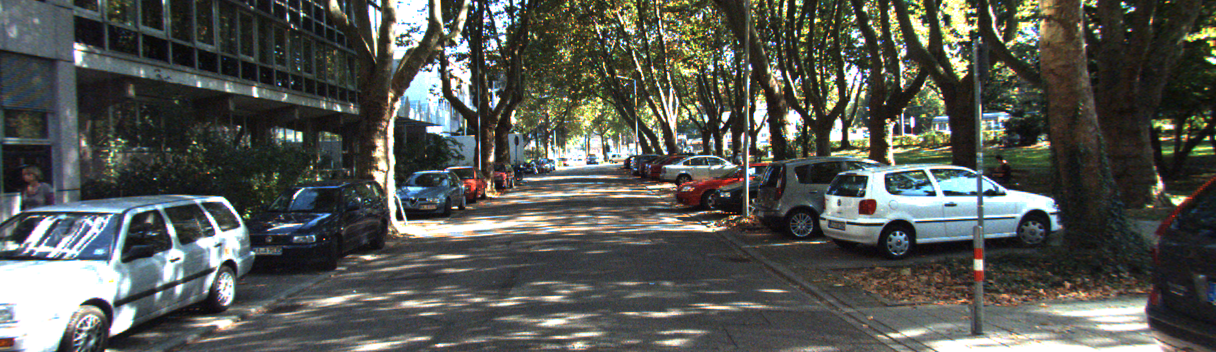

In [119]:
model = depthCompletionNew(1)
model = nn.DataParallel(model, device_ids=[0])
model.load_state_dict(pretrained_model["state_dict"])
model_n = model.module.normal
left = Image.open("0000000000.png")
sparse = Image.open("0000000000 _sparse.png")
left


In [ ]:
rmal.state_dict
left = Image.open("0000000000.png")
sparse = Image.open("0000000000 _sparse.png")
left


### 2. Prediction


In [120]:
def test_N(imgL,sparse,mask):
        model_n.eval()
    
        imgL= torch.from_numpy(imgL)
        sparse = torch.from_numpy(sparse)
        mask = torch.from_numpy(mask)

        imgL= Variable(imgL)
        sparse = Variable(sparse)
        mask = Variable(mask)

        imgL= imgL.float()
        sparse = sparse.float()
        mask = mask.float()

        start_time = time.time()
        with torch.no_grad():
            outN = model_n(imgL, sparse, mask)
        predN = outN[:,0,:,:]
        pred1 = predN 
        time_temp = (time.time() - start_time)

        output1 = torch.squeeze(pred1)

        return output1.data.cpu().numpy(),time_temp
    

In [130]:
def test(imgL,sparse,mask):
        model.eval()
    
        imgL= torch.from_numpy(imgL)
        sparse = torch.from_numpy(sparse)
        mask = torch.from_numpy(mask)

        imgL= imgL.float()
        sparse = sparse.float()
        mask = mask.float()
        
        imgL= Variable(imgL)
        sparse = Variable(sparse)
        mask = Variable(mask)

        

        start_time = time.time()
        with torch.no_grad():
            outC, outN, maskC, maskN = model(imgL, sparse, mask)

        tempMask = torch.zeros_like(outC)
        predC = outC[:,0,:,:]
        predN = outN[:,0,:,:]
        tempMask[:, 0, :, :] = maskC
        tempMask[:, 1, :, :] = maskN
        predMask = F.softmax(tempMask)
        predMaskC = predMask[:,0,:,:]
        predMaskN = predMask[:,1,:,:]
        pred1 = predC * predMaskC + predN * predMaskN
        time_temp = (time.time() - start_time)

        output1 = torch.squeeze(pred1)

        return output1.data.cpu().numpy(),time_temp
    

In [134]:
def test_NM(imgL,sparse,mask):
        model.eval()
    
        imgL= torch.from_numpy(imgL)
        sparse = torch.from_numpy(sparse)
        mask = torch.from_numpy(mask)

        imgL= imgL.float()
        sparse = sparse.float()
        mask = mask.float()
        
        imgL= Variable(imgL)
        sparse = Variable(sparse)
        mask = Variable(mask)

        

        start_time = time.time()
        with torch.no_grad():
            outC, outN, maskC, maskN = model(imgL, sparse, mask)

        tempMask = torch.zeros_like(outC)
        predC = outC[:,0,:,:]
        predN = outN[:,0,:,:]
        tempMask[:, 0, :, :] = maskC
        tempMask[:, 1, :, :] = maskN
        predMask = F.softmax(tempMask)
        predMaskC = predMask[:,0,:,:]
        predMaskN = predMask[:,1,:,:]
        pred1 = predN * predMaskN
        time_temp = (time.time() - start_time)

        output1 = torch.squeeze(pred1)

        return output1.data.cpu().numpy(),time_temp
    

In [149]:
processed = preprocess.get_transform(augment=False)
imgL_o = skimage.io.imread('2011_09_26_drive_0005_sync_image_0000000017_image_03.png')
imgL_o = np.reshape(imgL_o, [imgL_o.shape[0], imgL_o.shape[1],3])
imgL = processed(imgL_o).numpy()
imgL = np.reshape(imgL, [1, 3, imgL_o.shape[0], imgL_o.shape[1]])

'''gtruth = skimage.io.imread(gt_test[inx]).astype(np.float32)
gtruth = gtruth * 1.0 / 256.0'''
sparse = skimage.io.imread('2011_09_26_drive_0005_sync_velodyne_raw_0000000017_image_03.png').astype(np.float32)
sparse = sparse *1.0 / 256.0

mask = np.where(sparse > 0.0, 1.0, 0.0)
mask = np.reshape(mask, [imgL_o.shape[0], imgL_o.shape[1], 1])
sparse = np.reshape(sparse, [imgL_o.shape[0], imgL_o.shape[1], 1])
sparse = processed(sparse).numpy()
sparse = np.reshape(sparse, [1, 1, imgL_o.shape[0], imgL_o.shape[1]])
mask = processed(mask).numpy()
mask = np.reshape(mask, [1, 1, imgL_o.shape[0], imgL_o.shape[1]])

In [ ]:
pred, time_temp = test_N(imgL, sparse, mask)
pred = np.where(pred <= 0.0, 0.9, pred)

In [136]:
normal = plt.imsave('normal1.png',pred)
normal

In [142]:
output1 = 'normal.png'
pred_show = pred * 256.0
pred_show = pred_show.astype('uint16')
res_buffer = pred_show.tobytes()
img = Image.new("I",pred_show.T.shape)
img.frombytes(res_buffer,'raw',"I;16")
img.save(output1)

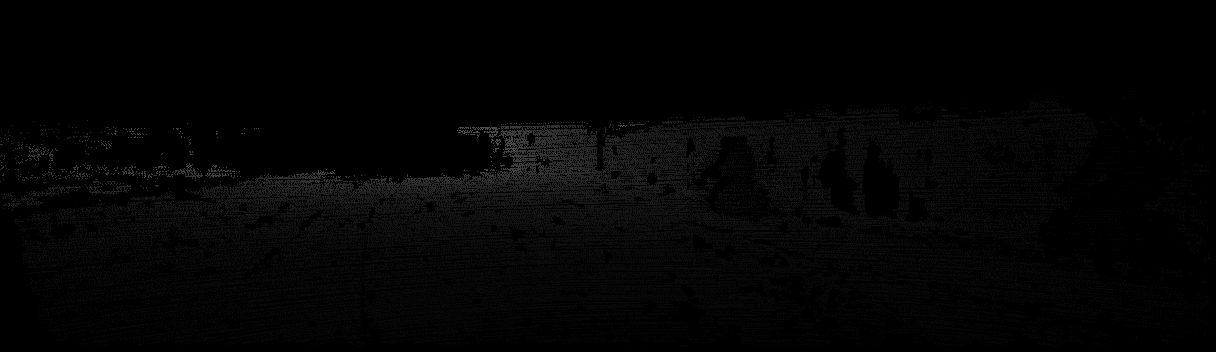

In [15]:
Y = load_image("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/dataset/depth_selection/val_selection_cropped/groundtruth_depth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png")
Y